# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import glob
import os
import wordcloud
#import dill


import pymorphy2
import nltk
import string

from sklearn import svm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# from thundersvm import SVC
from tqdm.notebook import tqdm, trange, tqdm_notebook

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

tqdm_notebook().pandas()

# %matplotlib inline

sns.set(style="darkgrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\newap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\newap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0it [00:00, ?it/s]

C:\Users\newap\anaconda3\lib\site-packages\tqdm\std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2]$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 


$$L^{'}_{w}(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i x_i}{1 + \exp(y_i(w^\top x_i + w_0)))} + \gamma \cdot sign(w) + 2\beta w$$.

$$L^{'}_{w_0}(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{-y_i}{1 + \exp(y_i(w^\top x_i + w_0)))}$$.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def m_1(x: List[float]) -> float:
    return np.linalg.norm(x, 1)

def m_2(x: List[float]) -> float:
    return np.linalg.norm(x, 2)

In [3]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return np.log(1 + np.exp(np.multiply(-y, (w@X.T + w0)))).mean() + gamma * m_1(w) + beta * (m_2(w) ** 2)

#### 3. [0.5 points] Implement the gradient (as a function)

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    sig = (-y) / (1 + np.exp(np.multiply(y, (w@X.T + w0))))
    grad_w0 = sig.mean()
    grad_w = ((sig@X) / len(y)) + gamma * np.sign(w) + 2 * beta * w    
    return grad_w, grad_w0

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    
    negative_class = -1
    positive_class = 1
    
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = None

    def fit(self, X, y):
        self.loss_history = []
        
        np.random.seed(self.random_state)
        
        self.w = np.random.sample(X.shape[1])
        self.w0 = np.random.sample(1)
        
        self.loss_history.append(self.calc_loss(X, y))
        
        for iter_num in trange(2, self.max_iter + 1):
            self.iter = iter_num
            
            if self.loss_history[-1] <= self.tolerance:
                print("Reached tolerance")
                return self
                
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w = self.w - self.lr * grad_w
            self.w0 = self.w0 - self.lr * grad_w0
            
            self.loss_history.append(self.calc_loss(X, y))

        return self

    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
            
        self_pred, _ = self.predict_proba(X)
        
        bin_classes = np.zeros_like(self_pred)
        
        bin_classes[self_pred < 0.5] = self.positive_class
        bin_classes[self_pred >= 0.5] = self.negative_class
        
        return bin_classes

        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])
    
    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """
        
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)

In [8]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [9]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

  0%|          | 0/999 [00:00<?, ?it/s]

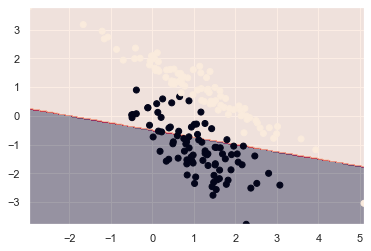

In [10]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

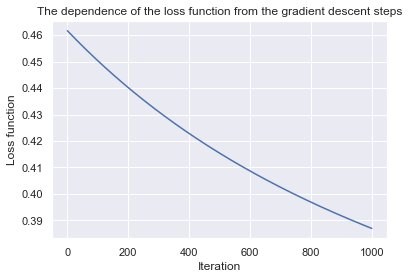

In [11]:
plt.plot([x for x in range(0, len(model.loss_history))], model.loss_history, label='The dependence of the loss function from the gradient descent steps')
plt.xlabel("Iteration")
plt.ylabel("Loss function")
plt.title('The dependence of the loss function from the gradient descent steps')
plt.show()

It can be seen that loss gets smaller over iteration, but change is not peaky.

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [13]:
def _precision(_y, _pred_y, _proba):
    return precision_score(_y, _pred_y, average='macro')

def _recall(_y, _pred_y, _proba):
    return recall_score(_y, _pred_y, average='macro')

def _f1(_y, _pred_y, _proba):
    return f1_score(_y, _pred_y, average='macro')

def _accuracy(_y, _pred_y, _proba):
    return accuracy_score(_y, _pred_y)

def _roc_auc(_y, _pred_y, _proba):
    return roc_auc_score(_y, _proba[:,1])

In [14]:
_metrics = {
    'Precision': _precision,
    'Recall': _recall,
    'F1-score': _f1,
    'Accuracy': _accuracy,
    'ROC-AUC': _roc_auc,
}

def show_results(_y, _pred_y, _proba):
    for metric_label in _metrics:
        try:
            print(f"{metric_label}: {_metrics[metric_label](_y, _pred_y, _proba):6.2f}")
        except (RuntimeError, TypeError, NameError, ValueError):
            pass
    print("\n")

def show_confusion_matrix(_y, _pred_y, ax = None, _labels = ['Negative', 'Positive']):
    
    _confusion_matrix = confusion_matrix(_y, _pred_y)
    sns.heatmap(ax=ax, data=_confusion_matrix, annot=True, fmt="d", cbar=False, xticklabels=_labels, yticklabels=_labels)

Linear

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


RBF

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


Poly

Precision:   0.98
Recall:   0.98
F1-score:   0.98
Accuracy:   0.98
ROC-AUC:   1.00


Poly, With Custom Degree

Precision:   0.82
Recall:   0.75
F1-score:   0.73
Accuracy:   0.74
ROC-AUC:   0.01




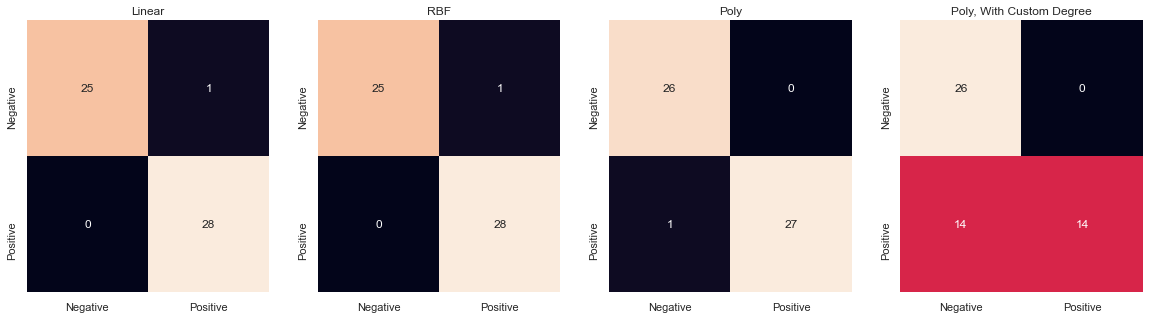

In [15]:
_models = {
    'Linear': svm.SVC(kernel='linear',probability=True),
    'RBF': svm.SVC(kernel='rbf',probability=True),
    'Poly': svm.SVC(kernel='poly',probability=True),
    'Poly, With Custom Degree': svm.SVC(kernel='poly', degree=8, probability=True),
}

_model_labels = [
    'Linear',
    'RBF',
    'Poly',
    'Poly, With Custom Degree',
]

np.random.seed(60)
fig, axs = plt.subplots(1, len(_model_labels), figsize=(20, 5))

for i in range(len(_model_labels)):
    _model_label = _model_labels[i]
    
    _model = _models[_model_label]
    _model.fit(X_train, y_train)
    
    ax = axs[i]
    ax.set_title(f"{_model_label}")
    
    y_pred = _model.predict(X_test)
    proba  = _model.predict_proba(X_test)
    
    print(f"{_model_label}\n")
    show_results(y_test, y_pred, proba)
    show_confusion_matrix(y_test, y_pred, ax)

It can be seen that among models, the best one were linear and rbf, as for poly it show better result using default degree=3, than with custom(degree=8).

In [16]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'decision_function_shape' : ['ovo', 'ovr']}

svr = svm.SVC(verbose = False, probability=True)

clf = GridSearchCV(svr, parameters, scoring='f1', cv=5, verbose=0, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
proba  = clf.predict_proba(X_test)
show_results(y_test, y_pred, proba)

print('Best parameters: ', clf.best_params_)

Precision:   1.00
Recall:   1.00
F1-score:   1.00
Accuracy:   1.00
ROC-AUC:   1.00


Best parameters:  {'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'poly'}


It can be seen that the best kernel is poly with C = 10 and using ovo as decision function shape.

In [17]:
my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01, 0.1, 1, 10, 100]}
svr = svm.SVC(verbose = False, probability=True)
clf = GridSearchCV(svr, parameters, scoring = 'f1', cv=5, verbose=0, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)

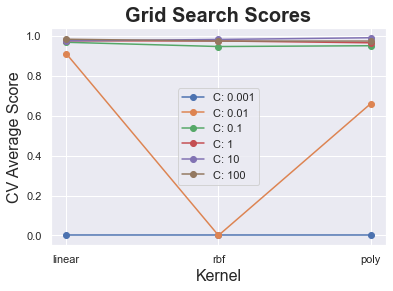

In [18]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best")
    ax.grid('on')

kernels = ['linear', 'rbf', 'poly']
C = [0.001, 0.01, 0.1, 1, 10, 100]

# Calling Method 
plot_grid_search(clf.cv_results_, kernels, C, 'Kernel', 'C')

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [19]:
DATA_ZIP_FILE_PATH = 'prose.zip'
DATA_DIR_PATH = 'prose'

if not os.path.exists(DATA_DIR_PATH):
    print("Extracting data...")
    
    with zipfile.ZipFile(DATA_ZIP_FILE_PATH, "r") as zip:
        zip.extractall(DATA_DIR_PATH)
    
    print("Done.")

In [20]:
AUTHORS_GLOB_PATTERN = f"{DATA_DIR_PATH}/*"
AUTHORS_GLOB_DIR_PATTERNS = glob.glob(AUTHORS_GLOB_PATTERN)

authors = list(map(lambda x: x[len(AUTHORS_GLOB_PATTERN) - 1:], AUTHORS_GLOB_DIR_PATTERNS))
authors

['Bryusov', 'Chekhov', 'Dostoevsky', 'Gogol', 'Gorky', 'Tolstoy']

In [21]:
def tokenize(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return nltk.tokenize.sent_tokenize(f.read())

In [22]:
df = pd.DataFrame([],columns = ['sentence', 'author'])
author_df = []

for i in range(len(authors)):
    author = authors[i]
    author_df.append(pd.DataFrame([],columns = ['sentence', 'author']))
    
    for filename in glob.glob(AUTHORS_GLOB_DIR_PATTERNS[i] + '/*.txt'):
        data = [[sentence, author] for sentence in tokenize(filename)]
        author_df[i] = author_df[i].append(pd.DataFrame(data,columns = ['sentence', 'author']))
        df = df.append(author_df[-1], ignore_index=True)

df

,sentence,author
0,Валерий Яковлевич Брюсов.,Bryusov
1,Алтарь победы\n\nКнига первая.,Bryusov
2,I\n\n Наш корабль уже был в виду берегов Ита...,Bryusov
3,"Скромному провинциалу, сыну удаленной Аквитани...",Bryusov
4,"В тот час я не думал о жестоких унижениях, нан...",Bryusov
...,...,...
8155028,Николай Семеныч был доволен справедливостью ...,Tolstoy
8155029,"Мари была спокойна,\n потому что Гога сходил ...",Tolstoy
8155030,"Доктор был доволен тем, что предложенные им\n...",Tolstoy
8155031,"Валя был доволен тем, что съел целую таре...",Tolstoy


In [23]:
for i in range(len(author_df)):
    author_df[i] = author_df[i][author_df[i].sentence.str.len() >= 15]
    
df = df[df.sentence.str.len() >= 15]
df

,sentence,author
0,Валерий Яковлевич Брюсов.,Bryusov
1,Алтарь победы\n\nКнига первая.,Bryusov
2,I\n\n Наш корабль уже был в виду берегов Ита...,Bryusov
3,"Скромному провинциалу, сыну удаленной Аквитани...",Bryusov
4,"В тот час я не думал о жестоких унижениях, нан...",Bryusov
...,...,...
8155028,Николай Семеныч был доволен справедливостью ...,Tolstoy
8155029,"Мари была спокойна,\n потому что Гога сходил ...",Tolstoy
8155030,"Доктор был доволен тем, что предложенные им\n...",Tolstoy
8155031,"Валя был доволен тем, что съел целую таре...",Tolstoy


In [24]:
np.random.seed(42)
fracs = [30, 15, 7, 20, 40, 3]
fracs.sort()

df = pd.DataFrame([],columns = ['sentence', 'author'])
author_df.sort(key=lambda x: x.shape[0])

for i in range(len(author_df)):
    sampled = author_df[i].sample(fracs[i] * (10 ** 3))
    df = df.append(sampled, ignore_index=True)

df

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov
...,...,...
114995,С эдаким пройтись по бульвару было не только в...,Dostoevsky
114996,В описываемый момент в конце залы возвышалась ...,Dostoevsky
114997,21\n\nсекундант (франц.).,Dostoevsky
114998,И самые гордые из них — самыми-то пошлыми раба...,Dostoevsky


In [25]:
_stopwords = stopwords.words('russian')
_punctuations = string.punctuation + "".join(['—', '``', '«', "''", '–', '...', '•', '“', "'s", '»'])
_morph = pymorphy2.MorphAnalyzer()

In [26]:
def word_filter(word):
    return not (word in _stopwords or word in _punctuations or word.isdigit() or word.isnumeric())

In [27]:
def sentence_transform(sentence):
    _sentence = sentence.replace('-', ' ')
    return " ".join(filter(lambda x: word_filter(x), [_morph.parse(word)[0].normal_form for word in word_tokenize(_sentence)]))

In [29]:
#df.sentence = df.sentence.progress_apply(sentence_transform)

In [30]:
df.head()

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov


In [31]:
df.to_pickle('df.pickle') # save to run cells from current cell

In [32]:
unpickled_df = pd.read_pickle('df.pickle')

In [33]:
unpickled_df

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov
...,...,...
114995,С эдаким пройтись по бульвару было не только в...,Dostoevsky
114996,В описываемый момент в конце залы возвышалась ...,Dostoevsky
114997,21\n\nсекундант (франц.).,Dostoevsky
114998,И самые гордые из них — самыми-то пошлыми раба...,Dostoevsky


In [34]:
df = unpickled_df

In [35]:
train_texts, test_texts, train_y, test_y = train_test_split(df.sentence, df.author, train_size=0.33, random_state=42, stratify = df.author)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 100)
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names()[:10]

['без', 'более', 'будет', 'бы', 'был', 'была', 'были', 'было', 'быть', 'вам']

In [37]:
# Apply Bag-Of-Words to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [38]:
train_X.todense()[:2]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [39]:
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 100) # select the top 100 words
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names()[:10]

['без', 'более', 'будет', 'бы', 'был', 'была', 'были', 'было', 'быть', 'вам']

In [40]:
# Apply TF-IDF to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [41]:
# Example
train_X.todense()[:2] # show the first 2 rows

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

It can be seen that two methods shows the same result for features, as counting of the top words is the same. But heir vectorized output differs, not only by type(todense()) value types (int/float), also by the values as can be seen above.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [42]:
_authors = [author_df[0].iloc[0].author, author_df[1].iloc[0].author]
_authors

['Chekhov', 'Gogol']

In [43]:
_df = df[df.author.isin(_authors)]
_df

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov
...,...,...
9995,"Как, в самом деле, отказать такому гостю, кото...",Gogol
9996,"Халява, философ Хома Брут и ритор Тиберий Горо...",Gogol
9997,"Да не покажется читателю странным, что обе дам...",Gogol
9998,"Ах, какой сюрприз!",Gogol


In [44]:
_sizes = []
for author in _authors:
    _sizes.append(_df[_df.author == author].shape[0])
    print(_sizes[-1])

3000
7000


Classes not balanced!!!

In [45]:
_author_data = [_df[_df.author == author] for author in _authors]

In [46]:
_author_data[1] = _author_data[1].sample(_sizes[0])

In [47]:
_df = _author_data[0].append(_author_data[1], ignore_index=True)

In [48]:
_df

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov
...,...,...
5995,Старушка вскоре после отъезда нашего героя в т...,Gogol
5996,"позабыл, – сказал Платонов.",Gogol
5997,"Вы, господа, приготовляйтесь по своей части, а...",Gogol
5998,"227--230), по тому же, вероятно, (единственном...",Gogol


In [49]:
__classes = [1, -1]

def get_classes(author):
    return __classes[_authors.index(author)]

In [50]:
get_classes('Chekhov')

1

In [51]:
_texts = _df.sentence
_classes = [get_classes(x) for x in _df.author]

In [52]:
train_texts, test_texts, train_y, test_y = train_test_split(_texts, _classes, test_size=0.25, random_state=42, stratify = _classes)

In [53]:
vectorizer = CountVectorizer(max_features = 1000)
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names()[:10]

['iii',
 'андреевна',
 'андрей',
 'андрий',
 'анна',
 'антон',
 'аня',
 'артемий',
 'афанасий',
 'ах']

In [54]:
# Apply Bag-Of-Words to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [55]:
train_X = np.array(train_X.toarray())

In [56]:
test_X = np.array(test_X.toarray())

In [57]:
test_y = np.array(test_y)
train_y = np.array(train_y)

In [58]:
clf = Logit(0, 0)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
#dill.dump_session('notebook_env.db')

In [ ]:
#dill.load_session('notebook_env.db')

In [59]:
show_results(test_y, y_pred, proba)

Precision:   0.50
Recall:   0.50
F1-score:   0.38
Accuracy:   0.50




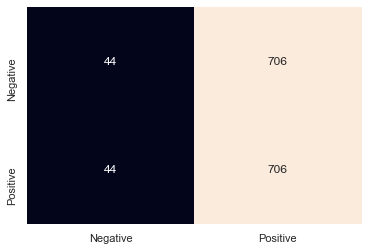

In [60]:
show_confusion_matrix(test_y, y_pred)

Not as good, as we wanted, results was not satisfing, maybe cross validation and parameter adjusting could fix it, but we can't know, see the last comment.

In [61]:
scores = cross_val_score(clf, train_X, train_y, cv=5)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [62]:
scores

array([0.49888889, 0.49222222, 0.50222222, 0.50444444, 0.50444444])

In [90]:
# parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#               'decision_function_shape' : ['ovo', 'ovr']}

# svr = svm.SVC(verbose = False, probability=True)

# clf = GridSearchCV(svr, parameters, scoring='f1', cv=5, verbose=0, n_jobs=-1)
# clf.fit(train_X, train_y)

# y_pred = clf.predict(test_X)
# proba  = clf.predict_proba(test_X)
# show_results(test_y, y_pred, proba)

# print('Best parameters: ', clf.best_params_)kernels = ['linear', 'rbf', 'poly']
# C = [0.001, 0.01, 0.1, 1, 10, 100]

# # Calling Method 
# plot_grid_search(clf.cv_results_, kernels, C, 'Kernel', 'C')

In [91]:
# parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# svr = svm.SVC(verbose = False, probability=True)

# clf = GridSearchCV(svr, parameters, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
# clf.fit(train_X, train_y)

# y_pred = clf.predict(test_X)
# proba  = clf.predict_proba(test_X)
# show_results(test_y, y_pred, proba)

# print('Best parameters: ', clf.best_params_)

As slow to run, thats why the blocks were commented

In [92]:
# kernels = ['linear', 'rbf', 'poly']
# C = [0.001, 0.01, 0.1, 1, 10, 100]

# # Calling Method 
# plot_grid_search(clf.cv_results_, kernels, C, 'Kernel', 'C')

Depends on block above

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [63]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(train_X, train_y)
y_pred =  clf.predict(test_X)
proba =  clf.predict_proba(test_X)

In [64]:
roc_auc_score(test_y, proba[:,1])

0.7446053333333333

In [65]:
fpr, tpr, thresholds = roc_curve(test_y, proba[:,1])
fnr = 1 - tpr

Text(0, 0.5, 'TPR')

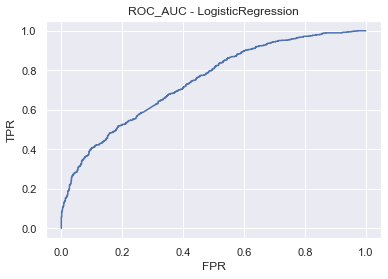

In [66]:
plt.plot(fpr, tpr)
plt.title("ROC_AUC - LogisticRegression")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [67]:
p_fnr = 0.3 # a threshold that your models have no more than 30% of false positive errors rate
t, _ = thresholds[fpr == min(fpr[fnr < p_fnr])]
t

0.49374634583563926

In [68]:
#Create a svm Classifier
clf = svm.SVC(kernel='poly', probability=True, C=1, decision_function_shape='ovo', random_state=42) # Linear Kernel

#Train the model using the training sets
clf.fit(train_X, train_y)

#Predict the response for test dataset
y_pred = clf.predict(test_X)
proba  = clf.predict_proba(test_X)

In [69]:
fpr, tpr, thresholds = roc_curve(test_y, proba[:,1])
fnr = 1 - tpr

Text(0, 0.5, 'TPR')

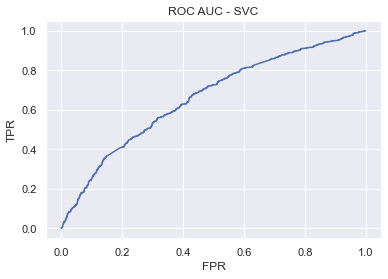

In [70]:
plt.plot(fpr, tpr)
plt.title("ROC AUC - SVC")
plt.xlabel("FPR")
plt.ylabel("TPR")

Text(0, 0.5, 'FNR')

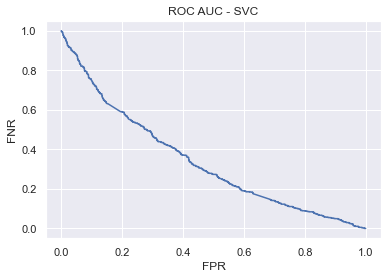

In [71]:
plt.plot(fpr, fnr)
plt.title("ROC AUC - SVC")
plt.xlabel("FPR")
plt.ylabel("FNR")

In [72]:
min(fpr[fnr < 0.3])

0.464

In [73]:
t, _ = thresholds[fpr == min(fpr[fnr < 0.3])]
t

0.5227694726559833

In [74]:
roc_auc_score(test_y, proba[:,1])

0.6615217777777778

We used ROC curve to find out threshold, where TPR is high and FPR is low as it ressults to more correct predictions (less misclassifications). It can be seen that LogisticRegression have lower threshold and roc_auc score then SVC.

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [75]:
df

,sentence,author
0,"— крикнул он, стараясь перекричать рев.",Chekhov
1,"Она слегка зарумянилась и, опустив глаза, стал...",Chekhov
2,— И здесь ладно.,Chekhov
3,"Но зато он дарил Ане кольца, браслеты и броши,...",Chekhov
4,"— Здравствуйте, Максим Федорыч!",Chekhov
...,...,...
114995,С эдаким пройтись по бульвару было не только в...,Dostoevsky
114996,В описываемый момент в конце залы возвышалась ...,Dostoevsky
114997,21\n\nсекундант (франц.).,Dostoevsky
114998,И самые гордые из них — самыми-то пошлыми раба...,Dostoevsky


In [76]:
__classes = list(range(6))

def get_classes(author):
    return __classes[authors.index(author)]

In [77]:
_texts = df.sentence
_classes = df.author

In [78]:
train_texts, test_texts, train_y, test_y = train_test_split(_texts, _classes, test_size=0.25, random_state=42, stratify = _classes)

In [79]:
vectorizer = TfidfVectorizer(max_features = 1000)
vectorizer.fit(train_texts)

# The top 10 words
vectorizer.get_feature_names()[:10]

['233',
 'de',
 'est',
 'et',
 'ii',
 'la',
 'le',
 'vous',
 'александрович',
 'александровна']

In [80]:
# Apply TF-IDF to train and test texts
train_X = vectorizer.transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [81]:
train_y = train_y.values
test_y = test_y.values
train_y_ = np.array(train_y)
test_y_ = np.array(test_y)

In [82]:
train_y

array(['Dostoevsky', 'Gorky', 'Dostoevsky', ..., 'Tolstoy', 'Tolstoy',
       'Dostoevsky'], dtype=object)

In [83]:
train_y_ = [get_classes(x) for x in train_y_]
test_y_ = [get_classes(x) for x in test_y_]

In [84]:
# clf = OneVsRestClassifier(Logit(0,0))
# clf.fit(train_X,  train_y_)

Commented as Logit don't have some internal implementations, you can try to uncomment and try to get the prediction data, using it

In [85]:
clf = OneVsRestClassifier(LogisticRegression(verbose = False, solver='lbfgs', max_iter=1000))
clf.fit(train_X,  train_y_)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000, verbose=False))

In [86]:
proba  = clf.predict_proba(test_X)
y_pred = clf.predict(test_X)

In [87]:
show_results(test_y_, y_pred, proba)

Precision:   0.43
Recall:   0.35
F1-score:   0.35
Accuracy:   0.51




C:\Users\newap\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


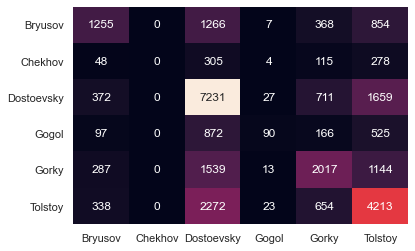

In [88]:
show_confusion_matrix(test_y_, y_pred, _labels=authors)

Not as good as we wanted.

In [89]:
# parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], \
#               'class_weight' : ['balanced', None], 'penalty':['l1', 'l2', 'elasticnet']}

# my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

# svr = OneVsRestClassifier(LogisticRegression(verbose = False,  solver='lbfgs', max_iter=1000))
# clf = GridSearchCV(svr, parameters, scoring=my_scorer)
# clf.fit(train_X, train_y_)
# predict = clf.predict_proba(test_X)
# print('OneVsRest Strategy')
# print('Best parameters: ', clf.best_params_)
# print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y_)))

As the gridvsearch is slow, cpu hits limit and kernel just drop it off, all progess lost and other factors, it is difficult to do steps were lots of calculations must be made, please take in mind.